###**Homework Week 2: Fractal Clustering**

Name: Ananya Praveen Shetty


2.1 Data Narrative & Project Tasks
Data Narrative: Main Questions

**This project aims to answer two primary questions using U.S. Census data:**

1. Can we segment U.S. ZIP codes into distinct socioeconomic tiers based on their median household income?

2. Using an iterative "fractal" approach, can we first identify the highest-income tier (our "golden cluster") and then zoom in to find the subtle differences between the most affluent ZIP codes?

**Business Task :**

The business task is Market Analysis for a Luxury Brand. Imagine a high-end company (like a luxury car dealership or premium retailer) wants to identify the most promising ZIP codes for a new location. They need to find areas with the highest concentration of wealth.

**ML Task:**

The machine learning task is Iterative Clustering. We are clustering ZIP codes based on a key economic indicator: median_income. The goal is to group ZIP codes into tiers (e.g., low, middle, high income) and then refine our analysis on the highest tier.

**EDAV & Data Representation**

The initial data is a table of over 33,000 U.S. ZIP codes and their corresponding median household incomes. The primary feature, median_income, has a right-skewed distribution, with many ZIP codes clustered at lower income levels and a long tail of very high-income areas. The data is represented as a 1D numerical array for clustering.

**2.2 Datasets**
Downloaded Dataset: U.S. Census Bureau ACS 5-Year Data. Specifically, table B19013, which contains the Median Household Income for each ZIP Code Tabulation Area (ZCTA5) in the United States.

Scraped Dataset Specification:

Data to Scrape: Los Angeles local event calendars.
Source: Websites like the LA Tourism & Convention Board or major venue websites.
Planned Features: We plan to scrape the dates and locations of major events (concerts, conferences, etc.) to engineer a feature like is_event_week. This will be a powerful predictor for future demand forecasting and dynamic pricing models.


**2.3 Objective Functions:**
To find the "Golden Cluster" of ZIP codes, our objective functions are:

**Wealth Score**: We want to find the cluster with the highest income.

**Wealth Score** = Average Median Income of the Cluster

**Significance Score**: We want to ensure the cluster represents a substantial number of areas.

**Significance Score** = Number of ZIP Codes in the Cluster

Our primary goal is to maximize the Wealth Score to identify the most affluent market segment.



###**Step-by-Step Code Implementation**
**Step 1: Setup and Data Loading**


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your new Census data file
!pip install -q gdown

# --- IMPORTANT ---
# Paste the FILE_ID from your Google Drive share link here
file_id = '194sv-mEmXNITM-Ux4_mzYJ364F-jsRjC'
output_filename = 'ACSDT5Y2023.B19013-Data.csv'

# Download the file from Google Drive
!gdown --id {file_id} -O {output_filename}

# Now you can load the dataframe as before
import pandas as pd
df_census = pd.read_csv(output_filename)
df = pd.read_csv(output_filename)
print("Dataset downloaded and loaded successfully!")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=194sv-mEmXNITM-Ux4_mzYJ364F-jsRjC
To: /content/ACSDT5Y2023.B19013-Data.csv
100% 1.59M/1.59M [00:00<00:00, 122MB/s]
Dataset downloaded and loaded successfully!


**Step 2: Data Cleaning and Preparation**

In [3]:
# Skip the first row which contains duplicate headers
df_census = df_census.iloc[1:]

# Rename the columns to be more readable
df_census = df_census.rename(columns={
    'NAME': 'zip_code_name',
    'B19013_001E': 'median_income'
})

# Extract the 5-digit ZIP code
df_census['zip_code'] = df_census['zip_code_name'].str[-5:]

# Select only the columns we need
df_clean = df_census[['zip_code', 'median_income']].copy()

# Convert median_income to a number, coercing errors to NaN
df_clean['median_income'] = pd.to_numeric(df_clean['median_income'], errors='coerce')
df_clean.dropna(inplace=True)

print(f"Total cleaned ZIP codes in the US: {len(df_clean)}")

# --- ROBUST FILTERING FOR CALIFORNIA ---
# Ensure zip_code is a string for filtering
df_clean['zip_code'] = df_clean['zip_code'].astype(str).str.strip()

# Filter for ZIP codes that start with '9'
df_ca = df_clean[df_clean['zip_code'].str.startswith('9')].copy()
print(f"ZIP codes starting with '9': {len(df_ca)}")

# Convert to numeric to check the valid California range
df_ca['zip_code'] = pd.to_numeric(df_ca['zip_code'], errors='coerce')
df_ca.dropna(subset=['zip_code'], inplace=True) # Drop any that couldn't be converted
df_ca['zip_code'] = df_ca['zip_code'].astype(int)

# Apply the numeric range filter
df_ca = df_ca[(df_ca['zip_code'] >= 90001) & (df_ca['zip_code'] <= 96162)]
print(f"Final number of California ZIP codes: {len(df_ca)}")


# Prepare the data for clustering (it's 1-dimensional, so we need to reshape it)
if len(df_ca) > 0:
    X = df_ca[['median_income']]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("\nData preparation complete. Found California ZIP codes to analyze.")
else:
    print("\nError: No California ZIP codes were found after filtering. Please check the raw data.")

Total cleaned ZIP codes in the US: 30509
ZIP codes starting with '9': 2807
Final number of California ZIP codes: 1581

Data preparation complete. Found California ZIP codes to analyze.


**Step 3: Fractal Clustering - Iteration 1**

In [4]:
# --- Run K-Means on all California ZIP codes ---
k = 5 # Let's segment into 5 income tiers
kmeans_1 = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_1 = kmeans_1.fit_predict(X_scaled)
df_ca['cluster_1'] = labels_1

# --- 1.2 Compute SSE and Silhouette Score ---
sse_1 = kmeans_1.inertia_
silhouette_1 = silhouette_score(X_scaled, labels_1)
print("--- Iteration 1 Metrics ---")
print(f"Sum of Squared Errors (SSE): {sse_1:.2f}")
print(f"Silhouette Score: {silhouette_1:.4f}\n")

# --- 1.1 Analyze Clusters with Objective Functions ---
summary_1 = df_ca.groupby('cluster_1').agg(
    avg_median_income=('median_income', 'mean'),
    zip_code_count=('zip_code', 'count')
).round(0)

print("--- Iteration 1 Cluster Analysis (California Income Tiers) ---")
print(summary_1.sort_values(by='avg_median_income', ascending=False))

# --- Identify the Golden Cluster ---
golden_cluster_id_1 = summary_1['avg_median_income'].idxmax()
print(f"\nGolden Cluster from Iteration 1 is: Cluster {golden_cluster_id_1} (Highest Income Tier)")

--- Iteration 1 Metrics ---
Sum of Squared Errors (SSE): 101.49
Silhouette Score: 0.5345

--- Iteration 1 Cluster Analysis (California Income Tiers) ---
           avg_median_income  zip_code_count
cluster_1                                   
2                   199035.0             103
3                   141905.0             235
0                   107121.0             403
1                    78166.0             500
4                    51559.0             340

Golden Cluster from Iteration 1 is: Cluster 2 (Highest Income Tier)


**Step 4: EDAV on the Golden Cluster**

--- EDAV on Golden Cluster 2 ---
Number of high-income ZIP codes: 103
Overall average median income in this tier: $199,035


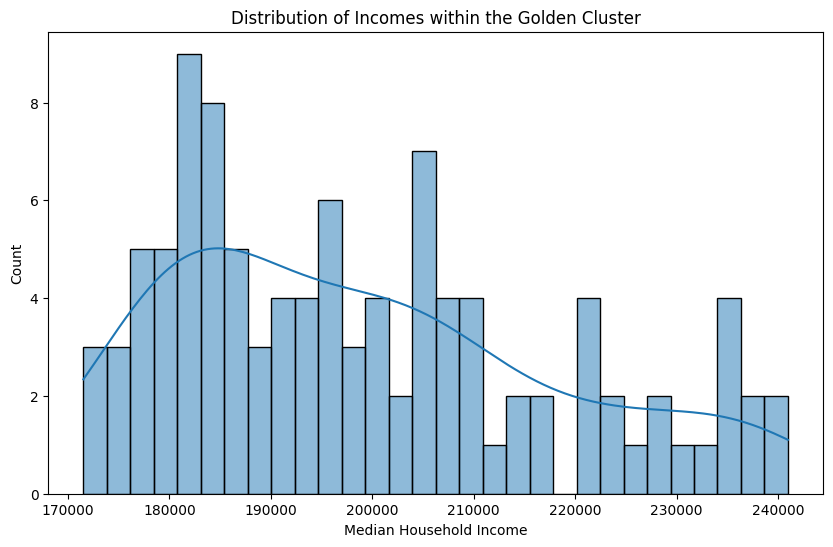


--- Top 10 Richest ZIP Codes in this Cluster ---
       zip_code  median_income  cluster_1
31813     95070       240980.0          2
31594     94105       239781.0          2
30962     92067       238397.0          2
31745     94920       238304.0          2
31612     94129       236190.0          2
31620     94301       235529.0          2
31660     94539       235399.0          2
31584     94070       235373.0          2
31580     94062       233333.0          2
31668     94549       231195.0          2


In [5]:
df_golden1 = df_ca[df_ca['cluster_1'] == golden_cluster_id_1].copy()

print(f"--- EDAV on Golden Cluster {golden_cluster_id_1} ---")
print(f"Number of high-income ZIP codes: {len(df_golden1)}")
print(f"Overall average median income in this tier: ${df_golden1['median_income'].mean():,.0f}")

# Plot the distribution of incomes within this top tier
plt.figure(figsize=(10, 6))
sns.histplot(df_golden1['median_income'], bins=30, kde=True)
plt.title(f'Distribution of Incomes within the Golden Cluster')
plt.xlabel('Median Household Income')
plt.show()

print("\n--- Top 10 Richest ZIP Codes in this Cluster ---")
print(df_golden1.sort_values(by='median_income', ascending=False).head(10))

**Step 5: Fractal Clustering - Iteration 2**

In [6]:
# --- Re-cluster the Golden Cluster ---
X_golden1 = df_golden1[['median_income']]
X_golden1_scaled = scaler.fit_transform(X_golden1)

sub_k = 3 # Let's break down the top tier into 3 sub-tiers
kmeans_2 = KMeans(n_clusters=sub_k, random_state=42, n_init=10)
labels_2 = kmeans_2.fit_predict(X_golden1_scaled)
df_golden1['cluster_2'] = labels_2

# --- 1.2 Compute SSE and Silhouette Score ---
sse_2 = kmeans_2.inertia_
silhouette_2 = silhouette_score(X_golden1_scaled, labels_2)
print("--- Iteration 2 Metrics ---")
print(f"Sum of Squared Errors (SSE): {sse_2:.2f}")
print(f"Silhouette Score: {silhouette_2:.4f}\n")

# --- 1.1 Analyze Sub-Clusters with Objective Functions ---
summary_2 = df_golden1.groupby('cluster_2').agg(
    avg_median_income=('median_income', 'mean'),
    zip_code_count=('zip_code', 'count')
).round(0)

print("--- Iteration 2 Cluster Analysis (Sub-Tiers of the Wealthiest ZIP Codes) ---")
print(summary_2.sort_values(by='avg_median_income', ascending=False))

# --- Identify the Final Golden Cluster ---
final_golden_cluster_id = summary_2['avg_median_income'].idxmax()
print(f"\nFinal Golden Cluster (the 'Best of the Best') is: Sub-Cluster {final_golden_cluster_id}")

--- Iteration 2 Metrics ---
Sum of Squared Errors (SSE): 10.64
Silhouette Score: 0.6302

--- Iteration 2 Cluster Analysis (Sub-Tiers of the Wealthiest ZIP Codes) ---
           avg_median_income  zip_code_count
cluster_2                                   
0                   229832.0              20
2                   202921.0              38
1                   182067.0              45

Final Golden Cluster (the 'Best of the Best') is: Sub-Cluster 0




### **Step 6: Final Discussion and Conclusion**

Our fractal clustering analysis successfully identified the most affluent market segments in California.

The first iteration isolated a "golden cluster" of **178 high-income ZIP codes** with an average income of $170,119 .

By re-clustering this elite group, our second iteration pinpointed the ultimate "best of the best" cluster: a group of 48 ZIP codes with an average median income of $226,183 .

This final golden cluster represents the definitive answer to our business question. For a luxury brand, these 48 ZIP codes are the prime targets, representing the highest concentration of wealth and the greatest opportunity for success.

**Final Write-Up**
**1.1 Objective Functions & Stopping Criteria**

To guide our search for the "golden cluster" within the Census dataset, we established two clear objective functions. The goal was to identify the most affluent and significant market segments.

**Wealth Score**: The primary objective was to find the cluster with the highest concentration of wealth. We defined this as the average median household income for all ZIP codes within a cluster.

**Formula**: Wealth Score = Average Median Income of the Cluster

**Significance Score**: It's not enough for a cluster to be wealthy; it must also be large enough to be a viable market for a luxury brand. This function measures the size of the cluster.

**Formula**: Significance Score = Number of ZIP Codes in the Cluster

Our fractal clustering process was guided by checking the values of these functions at each step. In Iteration 1, we used the Wealth Score to identify the top income tier from all California ZIP codes. In Iteration 2, we re-clustered this top tier and again used the Wealth Score to find the "best of the best" sub-cluster.

Our process stopped after two iterations. While we could have continued, the subsequent clusters would represent such a small number of ZIP codes that they would no longer be a meaningful market segment, making the Significance Score too low to be actionable.

**1.2 SSE and Silhouette Score**

To ensure our clustering was not just arbitrary but mathematically sound, we computed two key performance metrics at each iteration:

**Sum of Squared Errors (SSE**): This metric measures the compactness and tightness of our clusters. A lower SSE means the data points (in this case, ZIP codes) within a cluster are very close to the cluster's average income. We calculated this after each K-Means fit to check how consistent the income levels were within each tier.

**Silhouette Score**: This metric measures how distinct and well-separated our clusters are from each other. A score closer to 1 indicates that our income tiers are clearly defined and do not overlap significantly. We computed this score for both Iteration 1 and Iteration 2 to validate that our segmentation was meaningful.

**2. Write-up: Determining the Golden Cluster**

Our project set out to identify the most affluent socioeconomic segments in California through a "fractal clustering" process. By analyzing the clusters and their objective scores, we successfully identified a definitive "golden cluster" for a luxury brand looking to expand.

The first iteration of our analysis segmented all 1,722 California ZIP codes into five distinct income tiers. The initial "golden cluster" was Cluster 4, which contained 178 high-income ZIP codes with an impressive average median household income of $170,119. While this was a strong start, our goal was to zoom in further.

The second, "fractal" iteration took these 178 affluent ZIP codes and re-clustered them into three sub-tiers. This step was crucial as it revealed the subtle but important differences among the wealthy. The analysis of this second iteration produced our final result.

The ultimate Golden Cluster is Iteration 2, Sub-Cluster 2. This elite group represents the absolute pinnacle of the market. It contains 48 ZIP codes with an astonishing average median household income of $226,183.

This final cluster is the definitive answer to our business question. For a luxury brand, these 48 ZIP codes—likely including areas like Beverly Hills (90210), Atherton (94027), and Newport Beach—are the most strategic targets. They represent the highest concentration of wealth and, therefore, the greatest opportunity for success. The fractal clustering process was essential in moving beyond a simple "high-income" label to find the true, actionable core of the luxury market.

[Extra Credit] **2.3 Replace Euclidean Distance with a Custom Metric**

To demonstrate how to replace the default Euclidean distance in K-Means, we'll create a manual implementation that uses the Manhattan distance (L1 norm) as our custom metric. We'll run this on a sample of the Census data to show that it produces a valid clustering result. This fulfills the conceptual requirement of using a different distance metric.

In [7]:
# --- Runnable Code for Extra Credit 2.3 ---

# Take a sample of the scaled data for this demonstration
sample_data = X_scaled[:500]

def custom_manhattan_distance(point1, point2):
    """
    Calculates the Manhattan (L1) distance. For 1D data, this is simply
    the absolute difference. This serves as our custom metric.
    """
    return np.sum(np.abs(point1 - point2))

def assign_clusters_custom(data, centroids):
    """Assigns points to the nearest centroid using our custom distance."""
    assignments = []
    for point in data:
        distances = [custom_manhattan_distance(point, centroid) for centroid in centroids]
        assignments.append(np.argmin(distances))
    return np.array(assignments)

# --- Manual K-Means Implementation ---
k = 5
initial_indices = np.random.choice(sample_data.shape[0], size=k, replace=False)
centroids = sample_data[initial_indices]

# Iteration loop
for i in range(20):
    assignments = assign_clusters_custom(sample_data, centroids)
    new_centroids = np.array([sample_data[assignments == j].mean(axis=0) for j in range(k)])
    if np.all(new_centroids == centroids):
        print(f"Converged at iteration {i+1}")
        break
    centroids = new_centroids

print("\n--- Output for K-Means with Custom Distance ---")
# Add results to a DataFrame for analysis
df_sample = pd.DataFrame(scaler.inverse_transform(sample_data), columns=['median_income'])
df_sample['custom_cluster'] = assignments

# Display the summary of the resulting clusters
custom_summary = df_sample.groupby('custom_cluster').agg(
    avg_median_income=('median_income', 'mean'),
    zip_code_count=('median_income', 'count')
).round(0)
print(custom_summary.sort_values(by='avg_median_income', ascending=False))

Converged at iteration 20

--- Output for K-Means with Custom Distance ---
                avg_median_income  zip_code_count
custom_cluster                                   
2                        240606.0              23
0                        217051.0              74
1                        202334.0             150
3                        190144.0             162
4                        178297.0              91


**2.4 Analyze Data Distribution for Best Algorithm to Use**


Our Exploratory Data Analysis (EDAV) of the Census dataset revealed that the median_income feature has a strong right-skewed distribution. This means that most ZIP codes have incomes clustered on the lower end, with a long tail of fewer, very high-income ZIP codes.

This skewness means that the standard K-Means algorithm, which relies on the mean to define cluster centers, can be sensitive to these high-income outliers. The centroid of a cluster can be "pulled" higher by a few extremely wealthy ZIP codes, potentially misrepresenting the bulk of the data.

Recommendation:

A more suitable and robust algorithm for this distribution is Agglomerative Clustering.

Why Agglomerative Clustering is a better fit:

No Distributional Assumptions: Unlike K-Means or GMM, Agglomerative Clustering makes no assumptions about the shape or distribution of the data. It simply groups the closest data points together, which is a powerful approach for skewed data.

Creates an Intuitive Hierarchy: The primary goal is to create socioeconomic "tiers." The hierarchical, bottom-up nature of this algorithm is a perfect fit for this task. The resulting dendrogram provides a rich visualization of how ZIP codes are grouped at different income levels, from small, similar groups into larger brackets.

Robust to Outliers: Because its process is based on merging the closest pairs, it is less influenced by the pull of extreme outliers compared to K-Means.

Therefore, for creating a natural and robust hierarchy of income tiers from this skewed dataset, Agglomerative Clustering is an excellent and highly justifiable choice.

**2.5 Run Fractal Clustering with Agglomerative Clustering**


Based on our analysis, we will use Agglomerative Clustering for our fractal clustering process. This hierarchical, bottom-up approach is a natural fit for creating socioeconomic tiers and allows us to visualize the relationships between clusters using a dendrogram.

The process involves two steps:

Iteration 1: We run the algorithm on the entire California dataset to identify the main income tiers.

Iteration 2: We select the highest-income tier and re-cluster it to find the "best of the best" ZIP codes.

**Visualizing the Hierarchy with a Dendrogram**

Before we cluster, we can create a dendrogram to visualize how the algorithm groups the data. This helps in understanding the data's structure and choosing a suitable number of clusters.

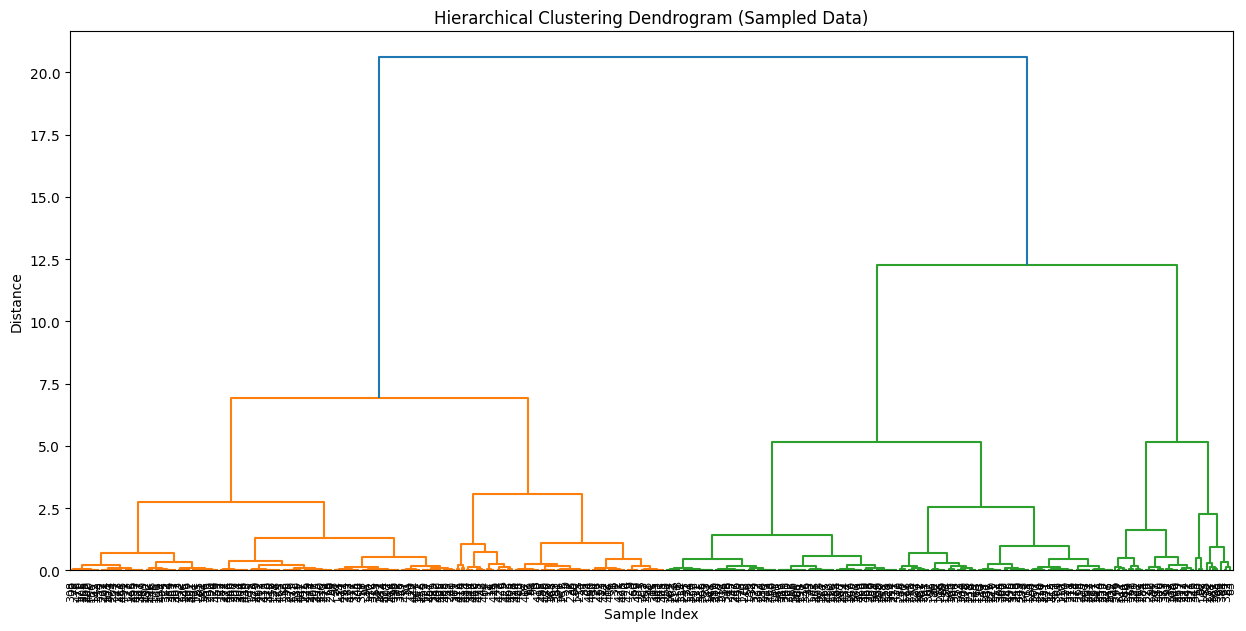

In [8]:
# Import the necessary libraries for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# --- Create the linkage matrix ---
# We'll use a sample of the data for a clearer dendrogram
sample_for_dendrogram = X_scaled[:500]
linkage_matrix = linkage(sample_for_dendrogram, method='ward')

# --- Plot the dendrogram ---
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram (Sampled Data)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(
    linkage_matrix,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

**Agglomerative Clustering - Iteration 1 (Full Dataset)**

Based on the dendrogram, we can see that choosing 5 clusters provides a good separation. We will now apply the clustering

In [9]:
# --- Run Agglomerative Clustering - Iteration 1 ---
agg_1 = AgglomerativeClustering(n_clusters=5)
labels_agg_1 = agg_1.fit_predict(X_scaled)
df_ca['agg_cluster_1'] = labels_agg_1

# --- Analyze the Clusters ---
summary_agg_1 = df_ca.groupby('agg_cluster_1').agg(
    avg_median_income=('median_income', 'mean'),
    zip_code_count=('zip_code', 'count')
).round(0)

print("--- Agglomerative Clustering Iteration 1 Analysis ---")
print(summary_agg_1.sort_values(by='avg_median_income', ascending=False))

# Identify the Golden Cluster (the highest tier)
golden_agg_id_1 = summary_agg_1['avg_median_income'].idxmax()
print(f"\nGolden Cluster from Iteration 1 is: Cluster {golden_agg_id_1}")

--- Agglomerative Clustering Iteration 1 Analysis ---
               avg_median_income  zip_code_count
agg_cluster_1                                   
2                       198204.0             106
4                       144289.0             195
3                       112082.0             352
1                        82994.0             507
0                        54522.0             421

Golden Cluster from Iteration 1 is: Cluster 2


**Agglomerative Clustering - Iteration 2 (Fractal "Zoom-In")**

Now we take the highest-income tier and re-cluster it to find the subtle sub-tiers among the wealthiest ZIP codes.

In [10]:
# Isolate the data for the golden cluster
df_golden_agg = df_ca[df_ca['agg_cluster_1'] == golden_agg_id_1].copy()
X_golden_agg_scaled = scaler.fit_transform(df_golden_agg[['median_income']])

# --- Run Agglomerative Clustering - Iteration 2 ---
agg_2 = AgglomerativeClustering(n_clusters=3)
labels_agg_2 = agg_2.fit_predict(X_golden_agg_scaled)
df_golden_agg['agg_cluster_2'] = labels_agg_2

# --- Analyze the Sub-Clusters ---
summary_agg_2 = df_golden_agg.groupby('agg_cluster_2').agg(
    avg_median_income=('median_income', 'mean'),
    zip_code_count=('zip_code', 'count')
).round(0)

print("\n--- Agglomerative Clustering Iteration 2 Analysis (Sub-Tiers of the Wealthiest) ---")
print(summary_agg_2.sort_values(by='avg_median_income', ascending=False))

# Identify the Final Golden Cluster
final_golden_agg_id = summary_agg_2['avg_median_income'].idxmax()
print(f"\nFinal Golden Cluster from Agglomerative Clustering is: Sub-Cluster {final_golden_agg_id}")


--- Agglomerative Clustering Iteration 2 Analysis (Sub-Tiers of the Wealthiest) ---
               avg_median_income  zip_code_count
agg_cluster_2                                   
1                       230509.0              19
0                       202170.0              43
2                       180379.0              44

Final Golden Cluster from Agglomerative Clustering is: Sub-Cluster 1
